In [1]:
!ls ../data

test                   train                  unet_brainMRI_seg.hdf5


In [2]:
!ls ../data/test

MildDemented     ModerateDemented NonDemented      VeryMildDemented


In [3]:
! pip install opencv-python -q
! pip install scikit-image -q

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import random
from skimage import exposure
from skimage.util import random_noise
from skimage import transform

### 1.0 Data Import

In [5]:
testdir = './../data/test'
traindir = './../data/train'
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

mildDem678.jpg
(208, 176)


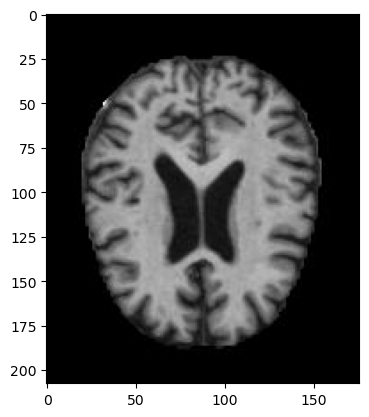

In [6]:
for category in categories:
    path = os.path.join(traindir, category) # path to dementia directory
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        print(img)
        print(img_array.shape)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

In [7]:
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(traindir, category) # path to dementia directory
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                training_data.append([img_array, class_num])

            except Exception as e:
                pass
        
create_training_data()

In [8]:
test_data = []

def create_test_data():
    for category in categories:
        path = os.path.join(testdir, category) # path to dementia directory
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                test_data.append([img_array, class_num])

            except Exception as e:
                pass
        
create_test_data()

In [9]:
print(len(training_data))
print(len(test_data))

5123
1279


In [10]:
df_train = pd.DataFrame(training_data)
df_test = pd.DataFrame(test_data)

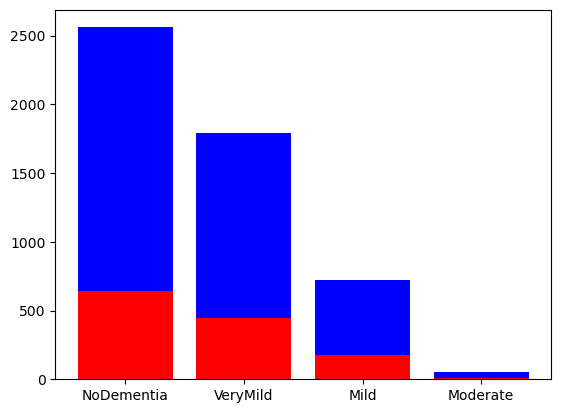

Test Data Counts: 
 2    2560
3    1792
0     719
1      52
Name: 1, dtype: int64 

 Train Data Counts: 
 2    640
3    448
0    179
1     12
Name: 1, dtype: int64


In [11]:
labels=['NoDementia', 'VeryMild', 'Mild', 'Moderate']
y1 = df_train[1].value_counts()
y2 = df_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

### 1.2 Data Generation for CNN (Data Augmentation)

Making data to improve the model

In [12]:
def horiz():
    return np.fliplr(img_array)

def vert():
    return np.flipud(img_array)

def rotat180():
    return transform.rotate(img_array, random.uniform(-180,20))

def noise():
    return random_noise(img_array, mode='s&p', clip=True)

In [13]:
func_ls = [horiz, vert, rotat180, noise]

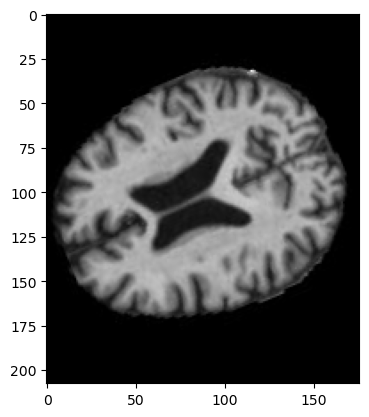

In [14]:
for category in categories:
    path = os.path.join(traindir, category) # path to dementia directory
    class_num = categories.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_image = random.choice(func_ls)()
        plt.imshow(new_image, cmap='gray')
        plt.show()
        break
    break
           

In [15]:
def img_augment():
    for category in categories:
        path = os.path.join(traindir, category) # path to dementia directory
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            new_image = random.choice(func_ls)()
            training_data.append([new_image, class_num]) #append transformed images
            
img_augment()

In [16]:
print(len(training_data))
print(len(test_data))

10246
1279


In [17]:
df_train = pd.DataFrame(training_data)
df_test = pd.DataFrame(test_data)

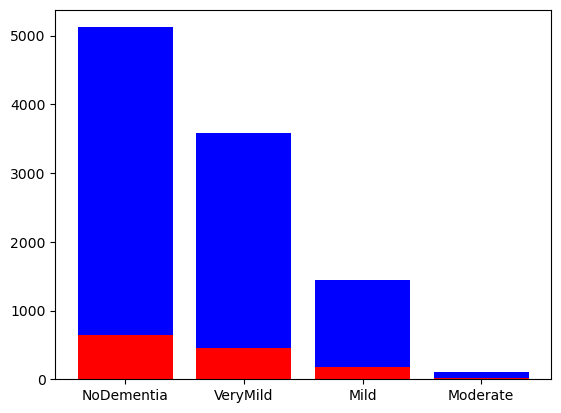

Test Data Counts: 
 2    5120
3    3584
0    1438
1     104
Name: 1, dtype: int64 

 Train Data Counts: 
 2    640
3    448
0    179
1     12
Name: 1, dtype: int64


In [18]:
labels=['NoDementia', 'VeryMild', 'Mild', 'Moderate']
y1 = df_train[1].value_counts()
y2 = df_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

10246
1279


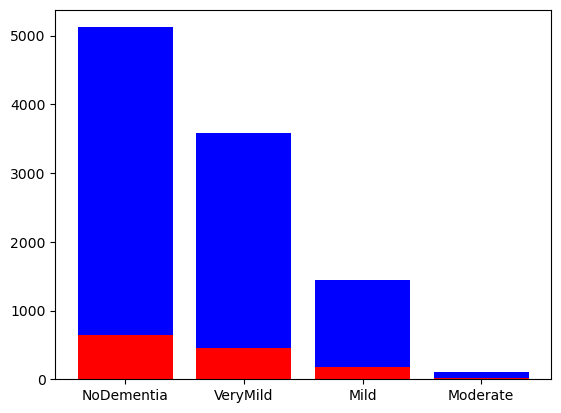

Test Data Counts: 
 2    5120
3    3584
0    1438
1     104
Name: 1, dtype: int64 

 Train Data Counts: 
 2    640
3    448
0    179
1     12
Name: 1, dtype: int64


In [19]:
print(len(training_data))
print(len(test_data))

df_train = pd.DataFrame(training_data)
df_test = pd.DataFrame(test_data)

labels=['NoDementia', 'VeryMild', 'Mild', 'Moderate']
y1 = df_train[1].value_counts()
y2 = df_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

### Shuffling training data before separation

In [20]:
df_train = df_train.sample(frac=1, random_state=1).reset_index()
df_train.drop(columns=df_train.columns[0], 
        axis=1, 
        inplace=True)

/var/folders/92/fmsgf0056l97n6qst76j75sm0000gp/T/ipykernel_11618/4225519578.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 640x480 with 0 Axes>

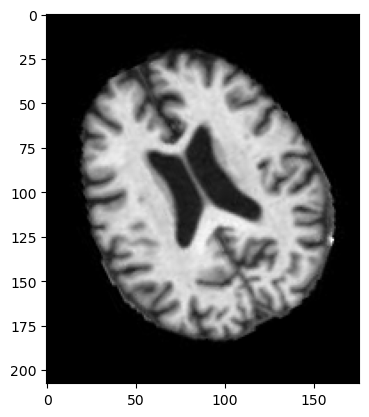

<Figure size 640x480 with 0 Axes>

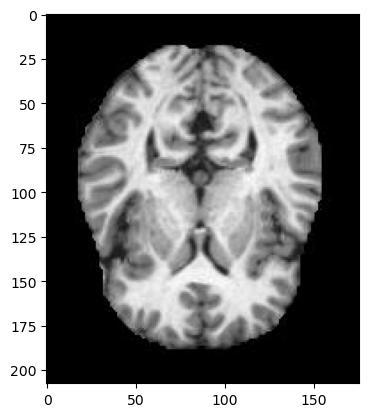

<Figure size 640x480 with 0 Axes>

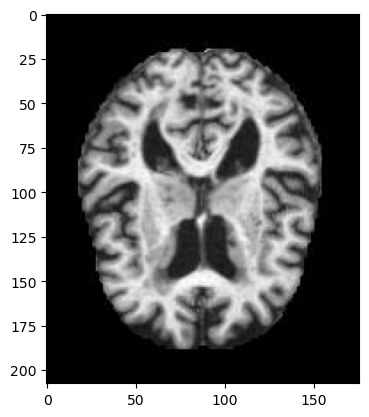

<Figure size 640x480 with 0 Axes>

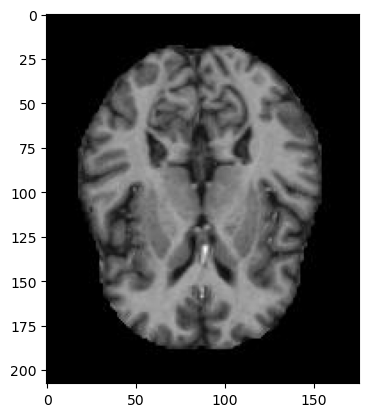

<Figure size 640x480 with 0 Axes>

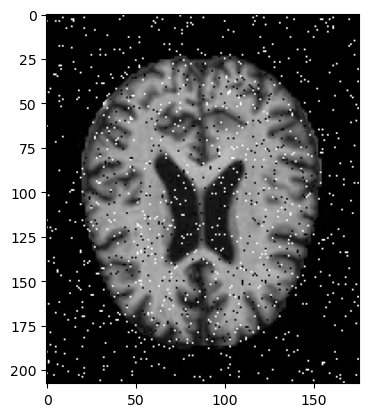

<Figure size 640x480 with 0 Axes>

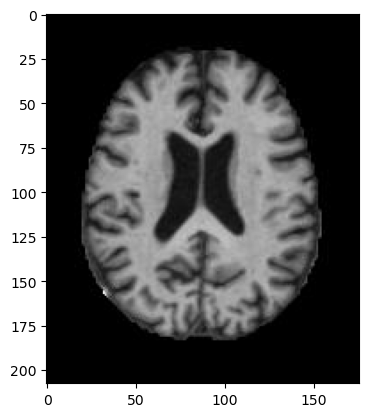

<Figure size 640x480 with 0 Axes>

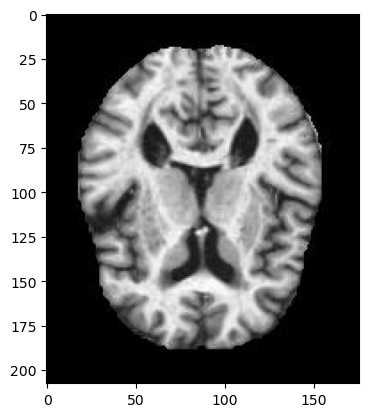

<Figure size 640x480 with 0 Axes>

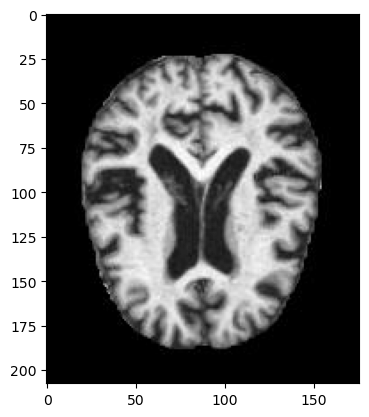

<Figure size 640x480 with 0 Axes>

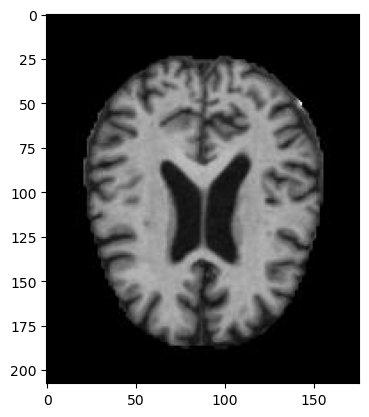

<Figure size 640x480 with 0 Axes>

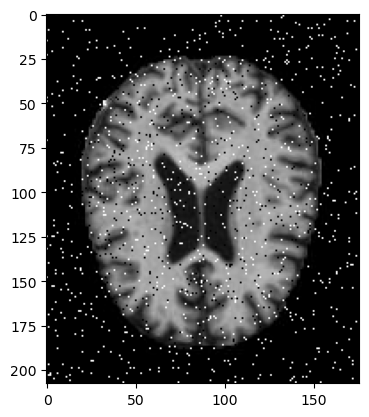

<Figure size 640x480 with 0 Axes>

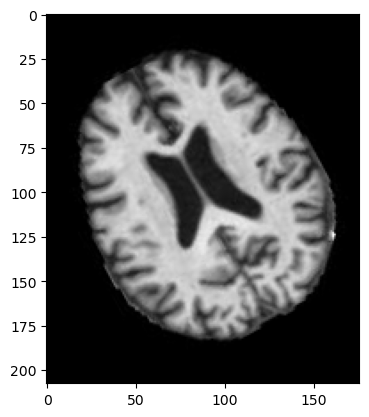

<Figure size 640x480 with 0 Axes>

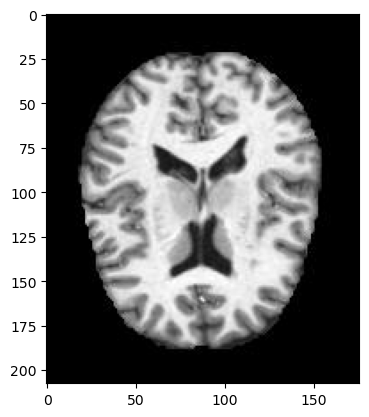

<Figure size 640x480 with 0 Axes>

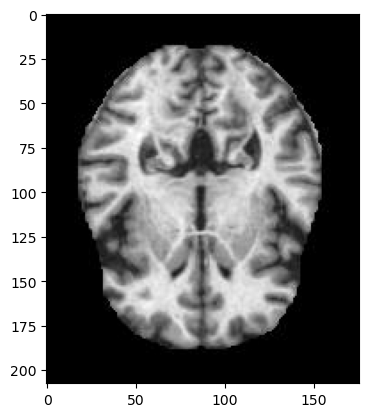

<Figure size 640x480 with 0 Axes>

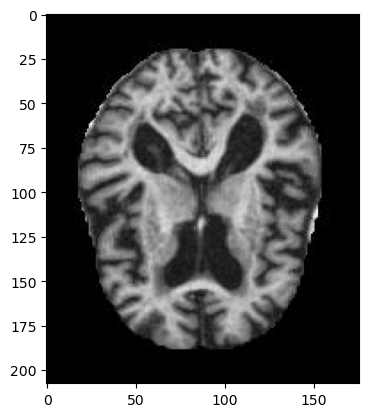

<Figure size 640x480 with 0 Axes>

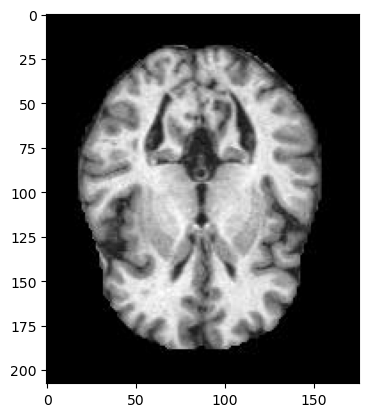

<Figure size 640x480 with 0 Axes>

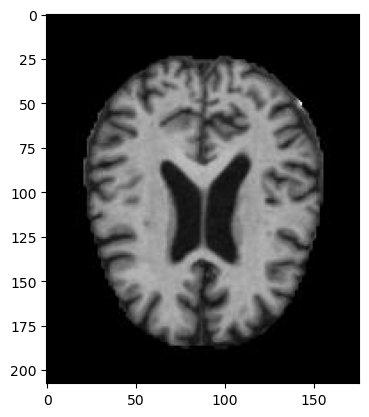

<Figure size 640x480 with 0 Axes>

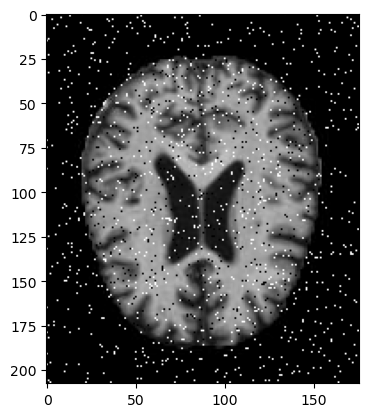

<Figure size 640x480 with 0 Axes>

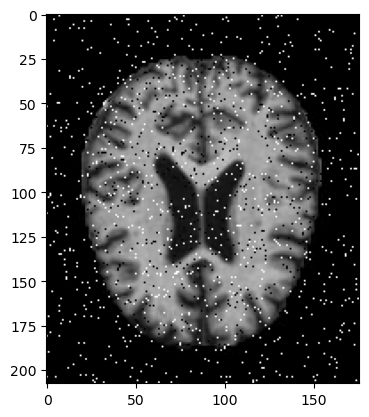

In [21]:
## Sanity check: ensuring training data is split and shuffled

for img in df_train.iloc[4982:5000,0]:
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,1) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr.imshow(img, cmap='gray')

### 1.1 Data Wrangling (Prep for Binary Classification + Multi-class Classification)

Since the data is heavily imbalanced, there is reason to include moderate, or late stage alzhiemer's (relative to our other categories) as an independent category. Instead, two different data formats will be tried: (a) binary classification of non-demented and demented (b) three way classificaion of non-demented, early-stage-demented, developed-demented. For the later, all 'moderate' will be reclassified as mild. 

All datasets will be shuffled in order to support model prediction.

In [22]:
### binary classification data

df_bin_train = df_train.copy()

In [23]:
df_bin_train[1]= df_bin_train[1].replace({3:1, 0:1})

In [24]:
df_bin_train[1] = df_bin_train[1].replace({2:0})

In [25]:
df_bin_test = df_test.copy()
df_bin_test[1] = df_bin_test[1].replace({3:1, 0:1})
df_bin_test[1] = df_bin_test[1].replace({2:0})

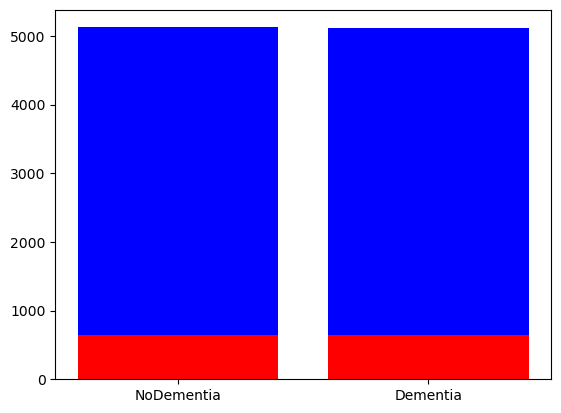

Test Data Counts: 
 1    5126
0    5120
Name: 1, dtype: int64 

 Train Data Counts: 
 0    640
1    639
Name: 1, dtype: int64


In [26]:
labels=['NoDementia', 'Dementia']
y1 = df_bin_train[1].value_counts()
y2 = df_bin_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

In [27]:
### Non, Early, Developed

df_tri_train = df_train.copy()
df_tri_train[1]= df_tri_train[1].replace({2:4})
df_tri_train[1]= df_tri_train[1].replace({0:2, 1:2})
df_tri_train[1]= df_tri_train[1].replace({3:1, 4:0})

df_tri_test = df_test.copy()
df_tri_test[1]= df_tri_test[1].replace({2:4})
df_tri_test[1]= df_tri_test[1].replace({0:2, 1:2})
df_tri_test[1]= df_tri_test[1].replace({3:1, 4:0})

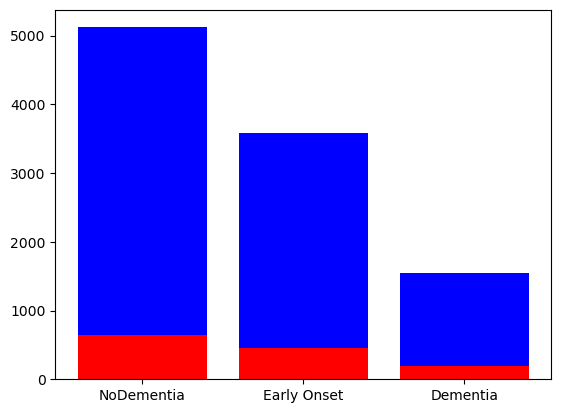

Test Data Counts: 
 0    5120
1    3584
2    1542
Name: 1, dtype: int64 

 Train Data Counts: 
 0    640
1    448
2    191
Name: 1, dtype: int64


In [28]:
labels=['NoDementia', 'Early Onset', 'Dementia']
y1 = df_tri_train[1].value_counts()
y2 = df_tri_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

In [29]:
### Sanity check: split data

<Figure size 640x480 with 0 Axes>

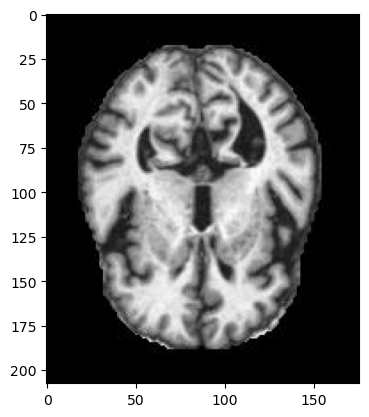

<Figure size 640x480 with 0 Axes>

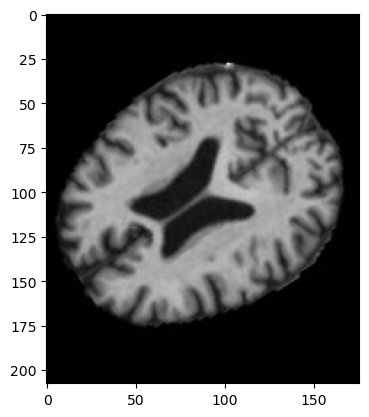

<Figure size 640x480 with 0 Axes>

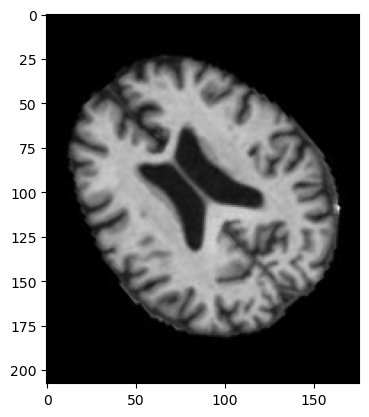

In [30]:
for img in df_bin_train.iloc[0:3,0]:
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,1) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr.imshow(img, cmap='gray')

In [31]:
df_bin_train.head()

,0,1
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


<Figure size 640x480 with 0 Axes>

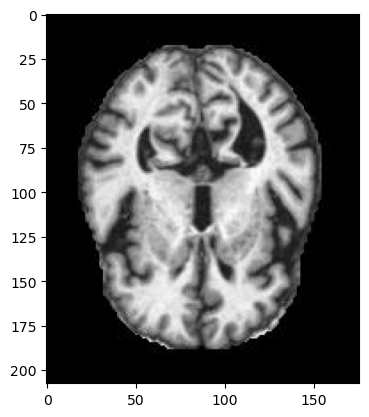

<Figure size 640x480 with 0 Axes>

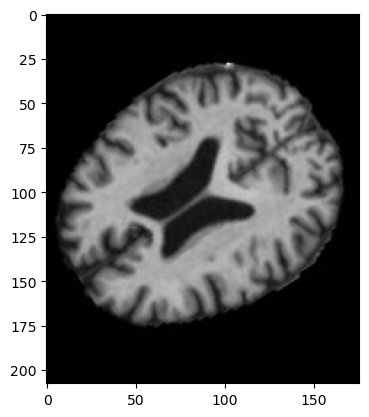

<Figure size 640x480 with 0 Axes>

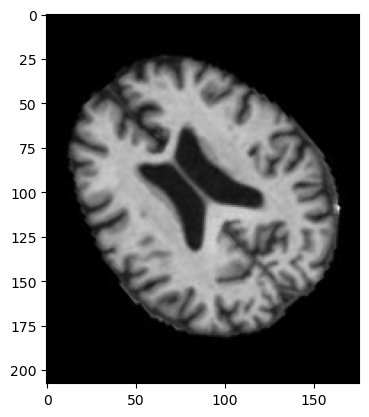

In [32]:
for img in df_tri_train.iloc[0:3,0]:
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,1) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr.imshow(img, cmap='gray')

In [33]:
df_tri_train.head()

,0,1
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [39]:
!ls ./../data

df_bin_train.pkl       train
test                   unet_brainMRI_seg.hdf5


In [38]:
df_bin_train.to_pickle('./../data/df_bin_train.pkl')

In [40]:
df_bin_test.to_pickle('./../data/df_bin_test.pkl')
df_tri_train.to_pickle('./../data/df_tri_train.pkl')
df_tri_test.to_pickle('./../data/df_tri_test.pkl')